15:30 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:30 bilby INFO    : Injected signal in H1:
15:30 bilby INFO    :   optimal SNR = 11.39
15:30 bilby INFO    :   matched filter SNR = 10.14-0.65j
15:30 bilby INFO    :   mass_1 = 32.0
15:30 bilby INFO    :   mass_2 = 30.0
15:30 bilby INFO    :   a_1 = 0.4
15:30 bilby INFO    :   a_2 = 0.3
15:30 bilby INFO    :   tilt_1 = 0.5
15:30 bilby INFO    :   tilt_2 = 1.0
15:30 bilby INFO    :   phi_12 = 1.7
15:30 bilby INFO    :   phi_jl = 0.3
15:30 bilby INFO    :   luminosity_distance = 2000.0
15:30 bilby INFO    :   theta_jn = 0.4
15:30 bilby INFO    :   psi = 2.659
15:30 bilby INFO    :   phase = 1.3
15:30 bilby INFO    :   geocent_time = 1126259642.413
15:30 bilby INFO    :   ra = 1.375
15:30 bilby INFO    :   dec = -1.2108
15:30 bilby INFO    : I

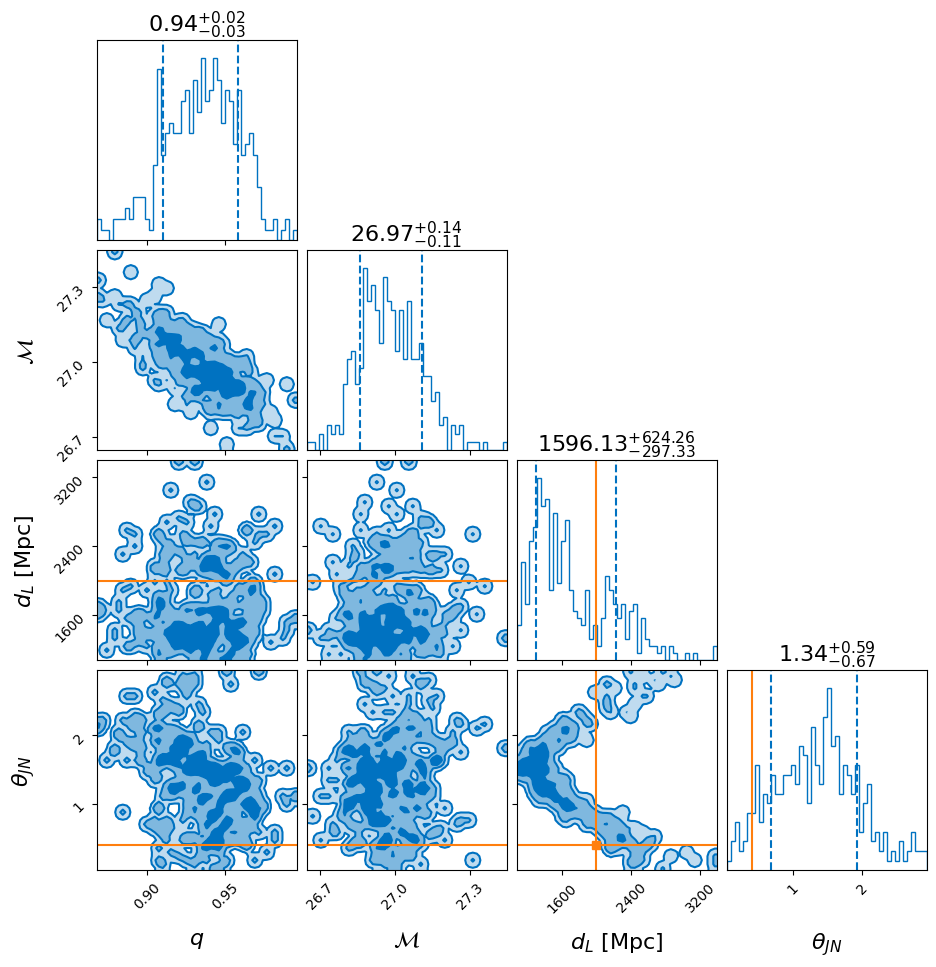

In [2]:
"""
Tutorial to demonstrate running parameter estimation on a reduced parameter
space for an injected signal.

This example estimates the masses using a uniform prior in both component masses
and distance using a uniform in comoving volume prior on luminosity distance
between luminosity distances of 100Mpc and 5Gpc, the cosmology is Planck15.
"""

import bilby

# Set the duration and sampling frequency of the data segment that we're
# going to inject the signal into
duration = 4.0
sampling_frequency = 2048.0
minimum_frequency = 20

# Specify the output directory and the name of the simulation.
outdir = "Final_week_attempt"
label = "Bilby_fast_tutorial"
bilby.core.utils.setup_logger(outdir=outdir, label=label)

# Set up a random seed for result reproducibility.  This is optional!
bilby.core.utils.random.seed(88170235)

# We are going to inject a binary black hole waveform.  We first establish a
# dictionary of parameters that includes all of the different waveform
# parameters, including masses of the two black holes (mass_1, mass_2),
# spins of both black holes (a, tilt, phi), etc.
injection_parameters = dict(
    mass_1=32.0,
    mass_2=30.0,
    a_1=0.4,
    a_2=0.3,
    tilt_1=0.5,
    tilt_2=1.0,
    phi_12=1.7,
    phi_jl=0.3,
    luminosity_distance=2000.0,
    theta_jn=0.4,
    psi=2.659,
    phase=1.3,
    geocent_time=1126259642.413,
    ra=1.375,
    dec=-1.2108,
)

# Fixed arguments passed into the source model
waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2",
    reference_frequency=50.0,
    minimum_frequency=minimum_frequency,
)

# Create the waveform_generator using a LAL BinaryBlackHole source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments,
)

# Set up interferometers.  In this case we'll use two interferometers
# (LIGO-Hanford (H1), LIGO-Livingston (L1). These default to their design
# sensitivity

ifos = bilby.gw.detector.InterferometerList(["H1", "L1"])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=duration,
    start_time=injection_parameters["geocent_time"] - 2,
)
ifos.inject_signal(
    waveform_generator=waveform_generator, parameters=injection_parameters
)

# for ifo in ifos:
#     ifo.set_strain_data_from_file("path/to/your/data.hdf5")

# Set up a PriorDict, which inherits from dict.
# By default we will sample all terms in the signal models.  However, this will
# take a long time for the calculation, so for this example we will set almost
# all of the priors to be equall to their injected values.  This implies the
# prior is a delta function at the true, injected value.  In reality, the
# sampler implementation is smart enough to not sample any parameter that has
# a delta-function prior.
# The above list does *not* include mass_1, mass_2, theta_jn and luminosity
# distance, which means those are the parameters that will be included in the
# sampler.  If we do nothing, then the default priors get used.
priors = bilby.gw.prior.BBHPriorDict()
for key in [
    "a_1",
    "a_2",
    "tilt_1",
    "tilt_2",
    "phi_12",
    "phi_jl",
    "psi",
    "ra",
    "dec",
    "geocent_time",
    "phase",
]:
    priors[key] = injection_parameters[key]

# Perform a check that the prior does not extend to a parameter space longer than the data
priors.validate_prior(duration, minimum_frequency)

# Initialise the likelihood by passing in the interferometer data (ifos) and
# the waveform generator
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator
)

# Run sampler.  In this case we're going to use the `dynesty` sampler
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    npoints=100,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
)

# Make a corner plot.
result.plot_corner()
